## ASTR777 Star and Planet Formation Problem Set 6
### Image Analysis - the spirals of IM Lup

In [1]:
import os, sys, time           
import numpy as np             
from astropy.io import fits
from astropy import wcs
from astropy.nddata.utils import Cutout2D
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import (AsinhStretch, LogStretch, ImageNormalize)
from scipy.interpolate import interp1d, interp2d
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [2]:
# set up plot parameters
import matplotlib as mpl
mpl.rc('xtick.major', size=5, pad=3, width=2)
mpl.rc('ytick.major', size=5, pad=3, width=2)
mpl.rc('xtick.minor', size=2, pad=3, width=2)
mpl.rc('ytick.minor', size=2, pad=3, width=2)
mpl.rc('axes', linewidth=2, labelsize=14, titlesize=18)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', markersize=5)
mpl.rc('font', size=12)
cmap = 'magma'

In [3]:
# disk target name
disk_name = 'IMLup'

# geometric properties (from Huang et al. 2018 DSHARP II)
offRA, offDEC = -0.001, +0.001
incl, PA = 47.5, 144.5
inclr, PAr = np.radians(incl), np.radians(PA)
rout = 1.2

In [4]:
# load the .FITS file contents
hdu = fits.open('IMLup_continuum.fits')
data = 1e3 * np.squeeze(hdu[0].data)
header = hdu[0].header
w = wcs.WCS(header)
w_ra_dec = w.sub(2)
# verify that the size is 4000x4000 with step size 0.03 arcsec
print(data.shape)

# cutout the central quarter region, 1.5 x 1.5 arcsec (1000 pixels)
cutout = Cutout2D(data, (2000, 2000), (1000, 1000), wcs=w_ra_dec)
image = cutout.data
print(image.shape)

(4000, 4000)
(1000, 1000)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
subhd = cutout.wcs.to_header()
ny, nx = image.shape
RAo = 3600 * subhd['CDELT1'] * (np.arange(nx) - (subhd['CRPIX1'] - 1))
DECo = 3600 * subhd['CDELT2'] * (np.arange(ny) - (subhd['CRPIX2'] - 1))
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC

freq = header['CRVAL3']
beam_maj, beam_min, beam_PA = 3600 * header['BMAJ'], 3600 * header['BMIN'], header['BPA']
beam_area = (np.pi * beam_maj * beam_min / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

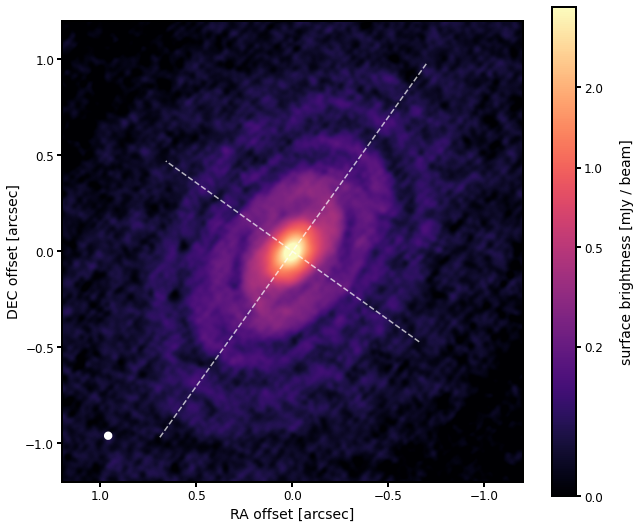

In [6]:
# image setups
im_bounds = (RAo_shift.max(), RAo_shift.min(), DECo_shift.min(), DECo_shift.max())
dRA_lims, dDEC_lims = [rout, -rout], [-rout, rout]

# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch(10))

# image plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

# minor and major axes
rmaj = np.linspace(-rout, rout, 2)
ax.plot(rmaj * np.sin(PAr), rmaj * np.cos(PAr), '--w', alpha=0.7)
ax.plot(rmaj * np.cos(inclr) * np.sin(PAr - 0.5*np.pi), 
        rmaj * np.cos(inclr) * np.cos(PAr - 0.5*np.pi), '--w', alpha=0.7)

# limits, labeling
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# beam
beam = Ellipse((dRA_lims[0] + 0.1*np.diff(dRA_lims), dDEC_lims[0] + 0.1*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [7]:
fig.savefig('IMLup_image.pdf')

## Derotated, deprojected Map

In [8]:
# function to (linearly) interpolate the map
f = interp2d(RAo_shift, DECo_shift, image, fill_value=0)

# deprojected array coordinates from -1.5 to 1.5 arcsec with same grid step size as sky image
disk_delt = 3600 * subhd['CDELT2']
nxd = nyd = 1001
i0 = nxd // 2
j0 = nyd // 2
xdisk = (np.arange(nxd)-i0)*(-disk_delt)
ydisk = (np.arange(nyd)-j0)*disk_delt
image_deproj = np.zeros((nyd, nxd))

# brute force pixel by pixel calculation through loops is slow...
for j in range(nyd):
    for i in range(nxd):
        # apply the inverse transformation to get to sky coordinates
        dra  = np.cos(PAr)*xdisk[i]*np.cos(inclr) + np.sin(PAr)*ydisk[j]
        ddec = -np.sin(PAr)*xdisk[i]*np.cos(inclr) + np.cos(PAr)*ydisk[j]
        image_deproj[j,i] = f(dra, ddec)

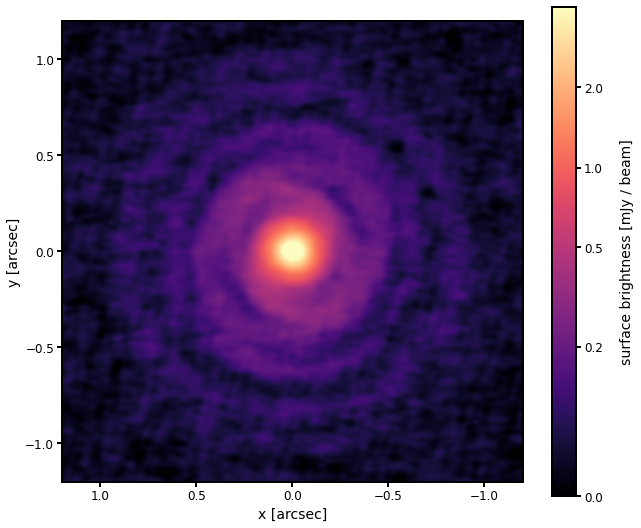

In [9]:
# plot the deprojected map - the rings should look like circles

deproj_bounds = (xdisk.max(), xdisk.min(), ydisk.min(), ydisk.max())
xdisk_lims, ydisk_lims = [rout, -rout], [-rout, rout]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(image_deproj, origin='lower', cmap=cmap, extent=deproj_bounds, norm=norm, aspect='equal')

ax.set_xlim(xdisk_lims)
ax.set_ylim(ydisk_lims)
ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')

# scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=90, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [10]:
fig.savefig('IMLup_deprojected.pdf')

## Deprojected Radius-Azimuth Map amd Radial Profile

In [11]:
f = interp2d(xdisk, ydisk, image_deproj, kind='cubic', fill_value=0)

# polar coordinates
dr = disk_delt
r = np.arange(dr, 2*rout, dr)
theta = np.linspace(-180, 180, 181)
image_polar = np.zeros((theta.size, r.size))

for j in range(theta.size):
    for i in range(r.size):
        # apply the inverse transformation to get to disk coordinates
        xd = some function of r and theta
        yd = some function of r and theta
        image_polar[j,i] = f(???)

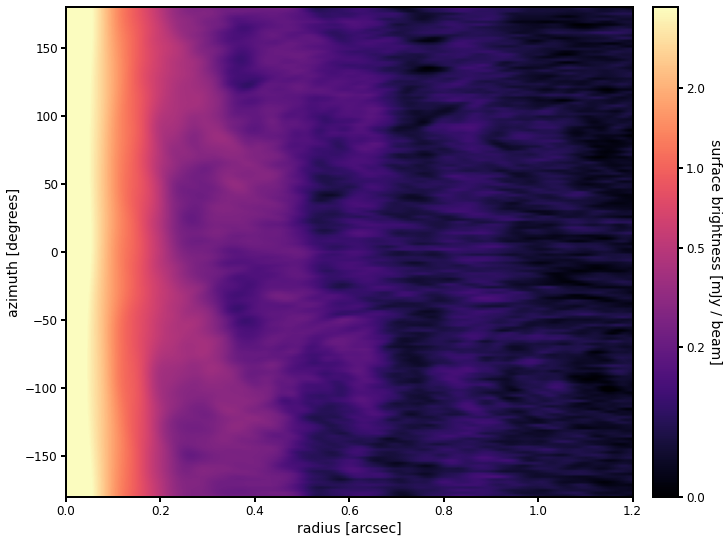

In [12]:
# image setups
polar_bounds = (r.min(), r.max(), theta.min(), theta.max())
r_lims = [0, rout]
theta_lims = [theta.min(), theta.max()]      

# set up and plot the images on the specified scale
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(image_polar, origin='lower', cmap=cmap, extent=polar_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(theta_lims)
#ax.grid()
ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.03)
cb.set_ticks([0, 0.2, 0.5, 1.0, 2.0])
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=17)

# adjust layout
fig.subplots_adjust(left=0.13, right=0.93, bottom=0.13, top=0.98)

In [13]:
fig.savefig('IMLup_polar.pdf')

Text(0, 0.5, '$T_b \\,\\,$ [K]')

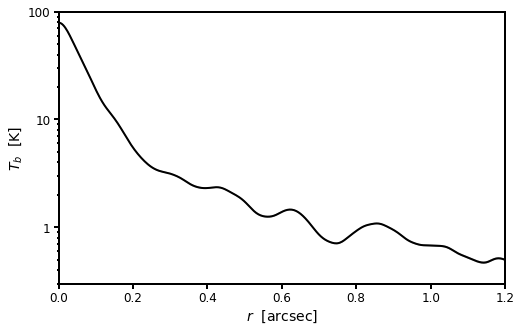

In [14]:
# plot the radial profile 

In [15]:
# save profile as a plot and ascii text file
fig.savefig('IMLup_radial_profile.pdf')
with open('IMLup_radial_profile.txt', 'w') as f:
    f.write('# r[asec] Tb[K]   Tb_err[K]\n')
    for i in range(r.size):
        f.write(f' {r[i]:6.3f}   {Tb[i]:6.3f} {Tb_err[i]:6.3f}\n')
f.close

<function TextIOWrapper.close()>

## create an azimuthally symmetric image from the radial profile and subtract it from the original to enhance the spirals

In [16]:
# radial profile that we will sweep out


Text(0.05, 0.9, 'Residual (x 10)')

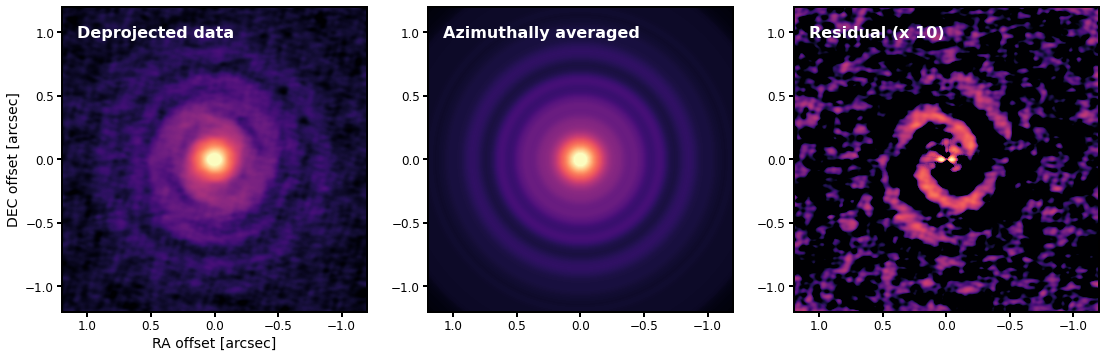

In [17]:
# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))

# image plot
gs = GridSpec(1,3, hspace=0.2, top=0.97, left=0.07, right=0.97)
fig = plt.figure(figsize=(16,7))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
axes = [ax0, ax1, ax2]

im = ax0.imshow(image_deproj, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imfit = ax1.imshow(image_sweep, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imres = ax2.imshow(10*(image_deproj-image_sweep), origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)
ax0.set_xlabel('RA offset [arcsec]')
ax0.set_ylabel('DEC offset [arcsec]')
ax0.text(0.05,0.9, 'Deprojected data', color='white', fontsize=16, fontweight='bold', transform=ax0.transAxes)

ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)
ax1.text(0.05,0.9, 'Azimuthally averaged', color='white', fontsize=16, fontweight='bold', transform=ax1.transAxes)

ax2.set_xlim(dRA_lims)
ax2.set_ylim(dDEC_lims)
ax2.text(0.05,0.9, 'Residual (x 10)', color='white', fontsize=16, fontweight='bold', transform=ax2.transAxes)

## Now transform back to the skyframe

In [18]:
set up the sweep coordinates
set up interp2d for the residual image
loop through the sweep coordinates

e.g.,

# function to (linearly) interpolate the map
f = interp2d(xsweep, ysweep, image_res, fill_value=0)

image_res_sky = np.zeros(image.shape)

for j in range(ny):
    for i in range(nx):
        x = ?
        y = ?
        image_res_sky[j,i] = f(x, y)

Text(0.05, 0.9, 'Azimuthal features (x3)')

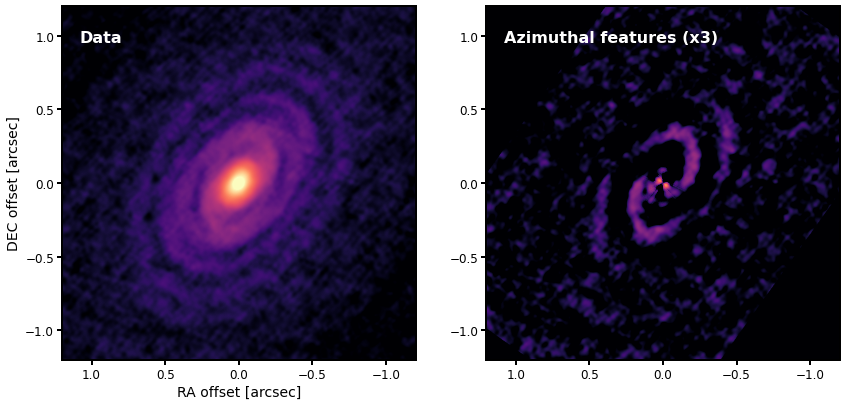

In [23]:
# intensity limits, and stretch
vmin, vmax = 0.0, 4.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch(0.03))

# image plot
gs = GridSpec(1,2, hspace=0.2, top=0.97, left=0.07, right=0.97)
fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
axes = [ax0, ax1]

im = ax0.imshow(image, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
imfit = ax1.imshow(3*image_res_sky, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')

ax0.set_xlim(dRA_lims)
ax0.set_ylim(dDEC_lims)
ax0.set_xlabel('RA offset [arcsec]')
ax0.set_ylabel('DEC offset [arcsec]')
ax0.text(0.05,0.9, 'Data', color='white', fontsize=16, fontweight='bold', transform=ax0.transAxes)

ax1.set_xlim(dRA_lims)
ax1.set_ylim(dDEC_lims)
ax1.text(0.05,0.9, 'Azimuthal features (x3)', color='white', fontsize=16, fontweight='bold', transform=ax1.transAxes)

In [24]:
fig.savefig('IMLup_spirals.pdf')